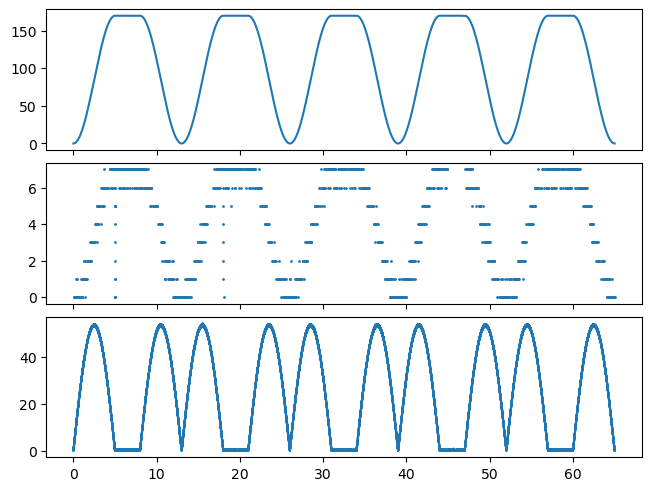

In [1]:
from src.simulate import make_simulated_data
import matplotlib.pyplot as plt
import numpy as np

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

is_ripple = np.zeros_like(time, dtype=bool)
for ripple_time in ripple_times:
    is_ripple |= (time >= ripple_time[0]) & (time <= ripple_time[1])


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True)
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)


In [2]:
from replay_trajectory_classification import Environment

env = Environment(place_bin_size=2.0).fit_place_grid(position[:, None])


Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


In [3]:
speed_knots = [0.5, 4.0, 20.0]


In [4]:
from src.test_non_local_switching_non_stationary_model import (
    setup_nonlocal_switching_model,
)

(
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    state_names,
) = setup_nonlocal_switching_model(
    is_ripple,
    spikes,
    position,
    speed,
    env,
    sampling_frequency=sampling_frequency,
    speed_knots=speed_knots,
    is_stationary_discrete_transition=True,
    include_no_spike_state=True,
    rw_movement_var=20.0
)


In [5]:
discrete_state_transitions.shape

(4, 4)

In [6]:
discrete_state_transitions.sum(axis=-1)

array([1., 1., 1., 1.])

In [7]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward


if discrete_transition_design_matrix is not None:
    predict_data = {"speed": np.arange(0, 50.0)}
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]


    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

    for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
        from_local_transition = centered_softmax_forward(
            predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
        )

        ax.plot(predict_data["speed"], from_local_transition)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Prob.")
        ax.legend(state_names)
        ax.set_title(f"From {from_state}")
        
    plt.ylim((0, 1.01))

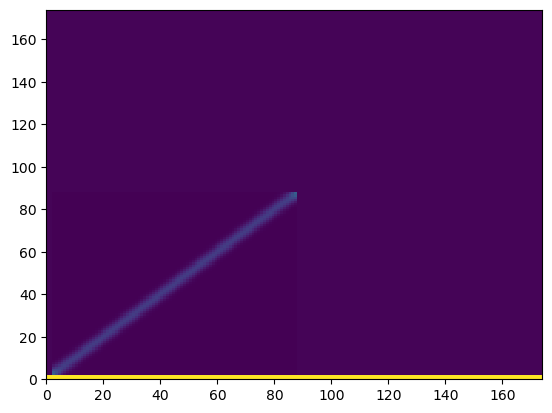

In [8]:
plt.pcolormesh(continuous_state_transitions.T)

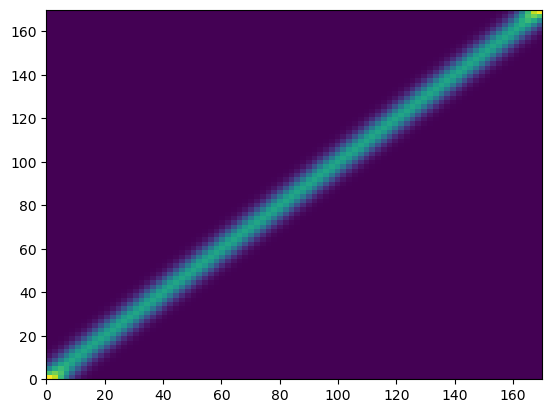

In [9]:
plt.pcolormesh(env.edges_[0], env.edges_[0], continuous_state_transitions[np.ix_(state_ind == 2, state_ind == 2)])

In [10]:
from src.test_non_local_switching_non_stationary_model import fit_switching_model

stickiness = np.zeros((4,1))
stickiness[0] = 65
stickiness[1] = 100_000
stickiness[2] = 65
stickiness[3] = 65

(
    predicted_state,
    acausal_posterior,
    acausal_state_probabilities,
    causal_posterior,
    marginal_log_likelihoods,
    initial_conditions,
    discrete_state_transitions,
    discrete_transition_coefficients,
    discrete_transition_design_matrix,
    non_local_rates,
) = fit_switching_model(
    spikes,
    emission_design_matrix,
    emission_predict_matrix,
    initial_conditions,
    discrete_state_transitions,
    continuous_state_transitions,
    state_ind,
    no_spike_rates,
    is_training,
    env,
    discrete_transition_coefficients=discrete_transition_coefficients,
    discrete_transition_design_matrix=discrete_transition_design_matrix,
    max_iter=100,
    fit_inital_conditions=True,
    fit_discrete_transition=True,
    fit_likelihood=False,
    is_no_spike_transition_constant=False,  
    concentration=1.1,
    stickiness=stickiness,
)


[[9.99000000e-01 3.33333333e-04 3.33333333e-04 3.33333333e-04]
 [3.33333333e-03 9.90000000e-01 3.33333333e-03 3.33333333e-03]
 [6.66666667e-03 6.66666667e-03 9.80000000e-01 6.66666667e-03]
 [6.66666667e-03 6.66666667e-03 6.66666667e-03 9.80000000e-01]]
Likelihoods


  0%|          | 0/8 [00:00<?, ?it/s]

Expectation Step
Maximization Step
Stats
iteration 1, likelihood: -9413.7218437358
[[9.99506681e-01 1.77454694e-04 1.64673154e-04 1.51191108e-04]
 [1.55900076e-04 9.99673938e-01 8.63365746e-05 8.38251268e-05]
 [1.21252842e-02 7.81938183e-03 9.73811343e-01 6.24399119e-03]
 [1.23058339e-02 7.81008509e-03 6.25697635e-03 9.73627105e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 2, likelihood: -9379.473752242891, change: 34.248091492909225
[[9.99818005e-01 1.96416988e-05 8.73032064e-05 7.50498465e-05]
 [1.80915773e-05 9.99971811e-01 5.13222568e-06 4.96520877e-06]
 [1.74968684e-02 1.29334969e-03 9.75226541e-01 5.98324063e-03]
 [1.64393508e-02 1.15981642e-03 4.83664859e-03 9.77564184e-01]]
Likelihoods
Expectation Step
Maximization Step
Stats
iteration 3, likelihood: -9358.425697227864, change: 21.048055015027785
[[9.99865723e-01 9.35033389e-06 6.97341997e-05 5.51922012e-05]
 [8.55668034e-06 9.99987208e-01 2.14857343e-06 2.08647223e-06]
 [1.59767076e-02 6.29132113e-04 9.7

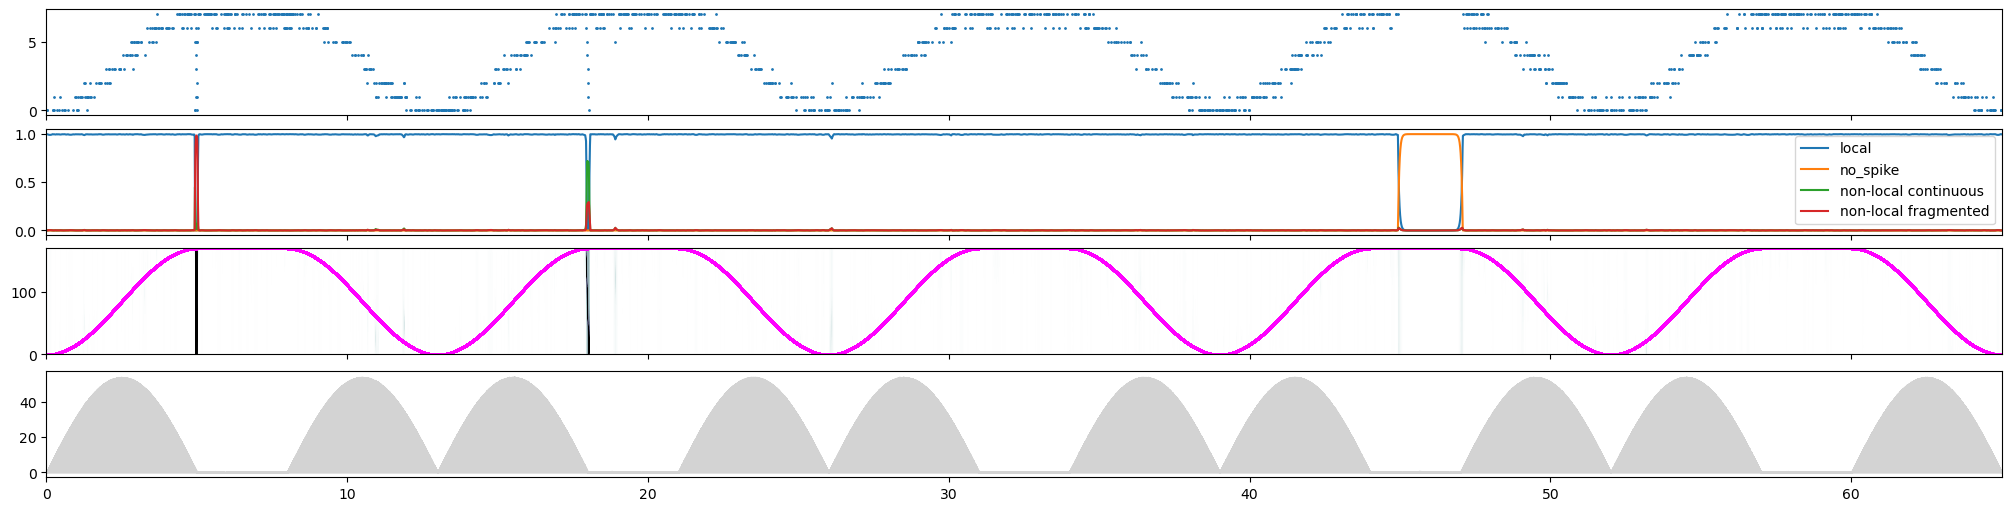

In [11]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    acausal_state_probabilities,
    acausal_posterior,
    state_names,
    time_slice=slice(0, len(time)),
    figsize=(20, 5)
)


In [12]:
causal_state_probabilities = np.zeros_like(acausal_state_probabilities)
for ind in range(len(state_names)):
    causal_state_probabilities[:, ind] = np.sum(causal_posterior[:, state_ind == ind], axis=1)

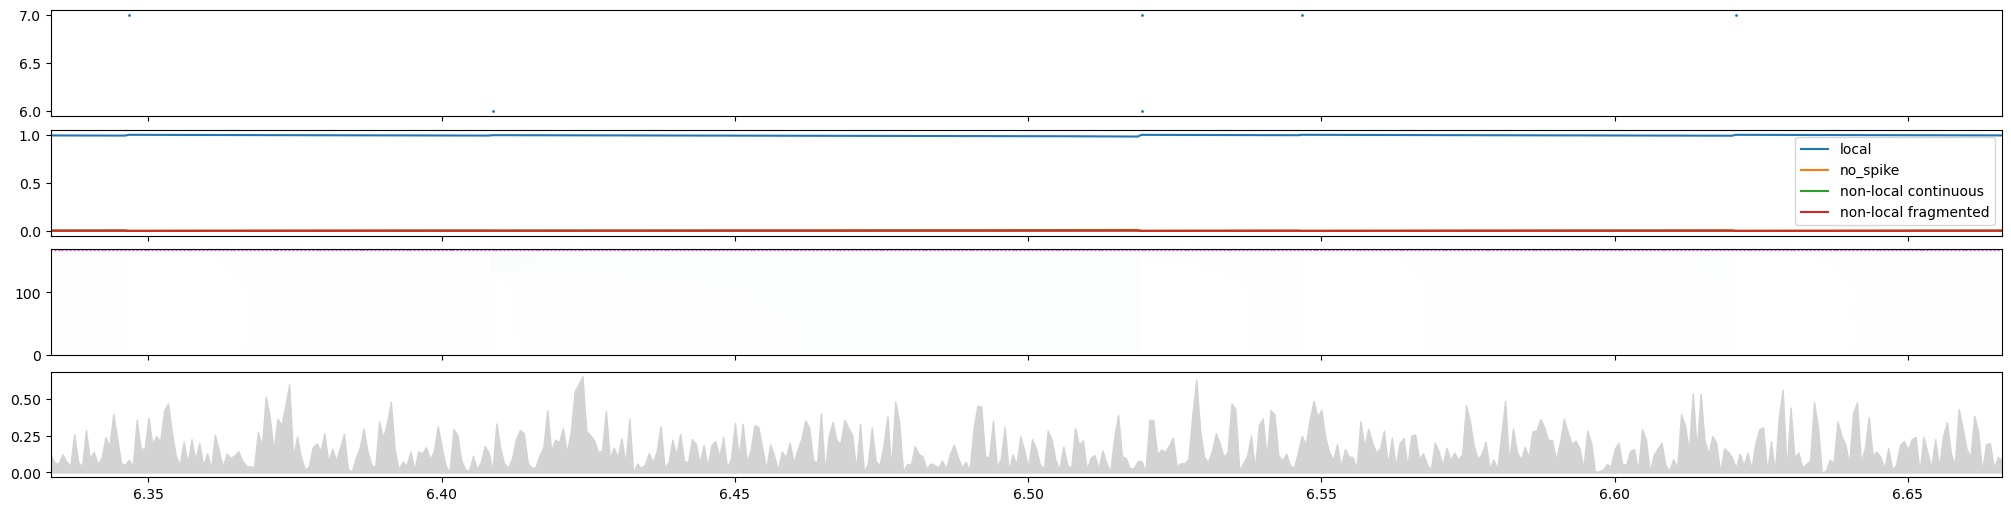

In [13]:
from src.test_non_local_switching_non_stationary_model import plot_switching_model

plot_switching_model(
    time,
    position,
    spikes,
    speed,
    non_local_rates,
    env,
    state_ind,
    causal_state_probabilities,
    causal_posterior,
    state_names,
    time_slice=slice(9500, 10_000),
    figsize=(20, 5)
)


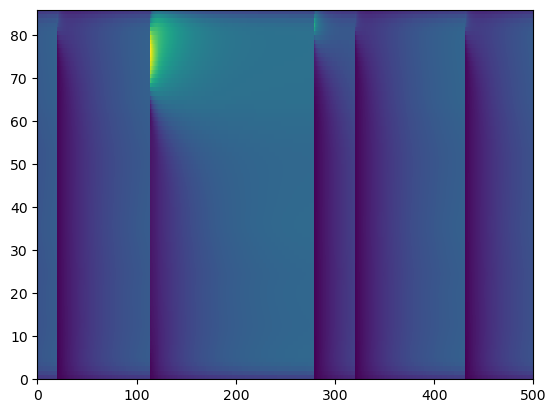

In [14]:
plt.pcolormesh(causal_posterior[slice(9500, 10_000), state_ind == 2].T)

In [15]:
discrete_state_transitions[0, 0]

0.999890088006406

In [16]:
discrete_state_transitions[1, 1]

0.9999873527305314

In [17]:
discrete_state_transitions[2, 2]

0.9801511058373308

In [18]:
discrete_state_transitions[3, 3]

0.9843748282209233

In [19]:
from patsy import build_design_matrices
import numpy as np
from src.hmm import centered_softmax_forward


if discrete_transition_design_matrix is not None:
    predict_data = {"speed": np.arange(0, 50.0)}
    predict_matrix = build_design_matrices(
        [discrete_transition_design_matrix.design_info], predict_data
    )[0]


    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))

    for from_state_ind, (ax, from_state) in enumerate(zip(axes.flat, state_names)):
        from_local_transition = centered_softmax_forward(
            predict_matrix @ discrete_transition_coefficients[:, from_state_ind]
        )

        ax.plot(predict_data["speed"], from_local_transition)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Prob.")
        ax.legend(state_names)
        ax.set_title(f"From {from_state}")
        
    plt.ylim((0, 1.01))
